<a href="https://colab.research.google.com/github/Bharathkumar1404/data-science-final-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
!pip install matplotlib

In [3]:
!pip install prophet

In [4]:
!pip install statsmodels

In [5]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Flatten
#from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [6]:
weather_data = pd.read_csv('pune.csv')
weather_data.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2008-12-11 00:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,10,31,72,0.0,1013,18,10,114,5,pune
1,2008-12-11 01:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,9,30,72,0.0,1013,19,10,125,4,pune
2,2008-12-11 02:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,8,29,72,0.0,1013,18,10,136,4,pune
3,2008-12-11 03:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,8,29,72,0.0,1013,18,10,147,4,pune
4,2008-12-11 04:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,7,23,68,0.0,1014,20,10,136,4,pune


In [7]:
wf = weather_data.drop(columns=['DewPointC','cloudcover','moonrise', 'moonset', 'sunrise', 'sunset','sunHour','totalSnow_cm','uvIndex','moon_illumination','visibility','winddirDegree','windspeedKmph'])

In [8]:
wf.head()

,date_time,maxtempC,mintempC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,humidity,precipMM,pressure,tempC,location
0,2008-12-11 00:00:00,30,18,18,18,18,10,72,0.0,1013,18,pune
1,2008-12-11 01:00:00,30,18,19,19,19,9,72,0.0,1013,19,pune
2,2008-12-11 02:00:00,30,18,18,18,18,8,72,0.0,1013,18,pune
3,2008-12-11 03:00:00,30,18,18,18,18,8,72,0.0,1013,18,pune
4,2008-12-11 04:00:00,30,18,20,20,20,7,68,0.0,1014,20,pune


In [9]:
wf['date_time'] = pd.to_datetime(wf['date_time'])
wf['year'] = wf['date_time'].dt.year
wf['month'] = wf['date_time'].dt.month
wf['day'] = wf['date_time'].dt.day
wf['hour'] = wf['date_time'].dt.hour

wf = wf[wf['year'] > 2008]
wf = wf[wf['year'] < 2022]

In [10]:
wf = wf.reset_index(drop= True)

In [11]:
print(wf.info())
print(wf.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date_time     113952 non-null  datetime64[ns]
 1   maxtempC      113952 non-null  int64         
 2   mintempC      113952 non-null  int64         
 3   FeelsLikeC    113952 non-null  int64         
 4   HeatIndexC    113952 non-null  int64         
 5   WindChillC    113952 non-null  int64         
 6   WindGustKmph  113952 non-null  int64         
 7   humidity      113952 non-null  int64         
 8   precipMM      113952 non-null  float64       
 9   pressure      113952 non-null  int64         
 10  tempC         113952 non-null  int64         
 11  location      113952 non-null  object        
 12  year          113952 non-null  int32         
 13  month         113952 non-null  int32         
 14  day           113952 non-null  int32         
 15  hour          113

In [12]:
missing_values = wf.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 date_time       0
maxtempC        0
mintempC        0
FeelsLikeC      0
HeatIndexC      0
WindChillC      0
WindGustKmph    0
humidity        0
precipMM        0
pressure        0
tempC           0
location        0
year            0
month           0
day             0
hour            0
dtype: int64


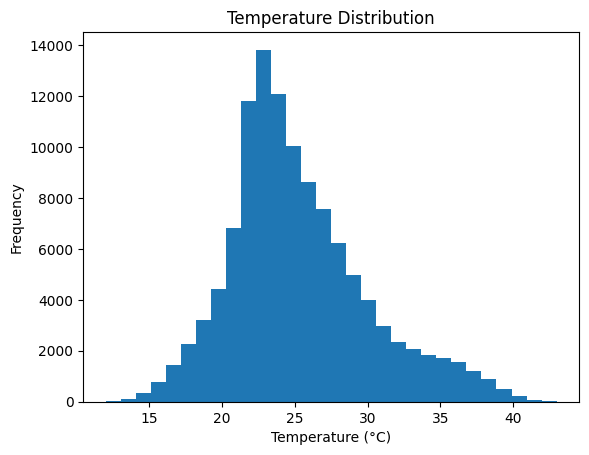

In [13]:
wf['tempC'].plot(kind='hist', bins=30, title='Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.show()

year
2009    25.416210
2010    24.967808
2011    25.084817
2012    25.401753
2013    25.117009
2014    25.387100
2015    25.354566
2016    25.123634
2017    25.451027
2018    25.830023
2019    25.528311
2020    25.433629
2021    25.333219
Name: tempC, dtype: float64


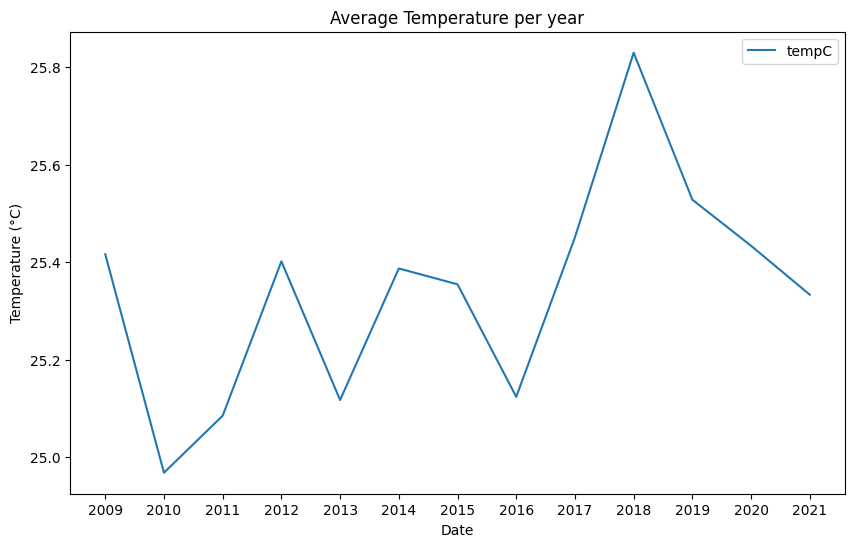

In [14]:
wf = wf.sort_values(by='date_time')
wfg = wf.groupby('year')['tempC'].mean()
print(wfg)

wfg = wfg.reset_index()
wfg.plot(x='year', y='tempC', kind='line', figsize=(10, 6))

plt.xticks(wfg['year'].unique())
plt.title('Average Temperature per year')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()


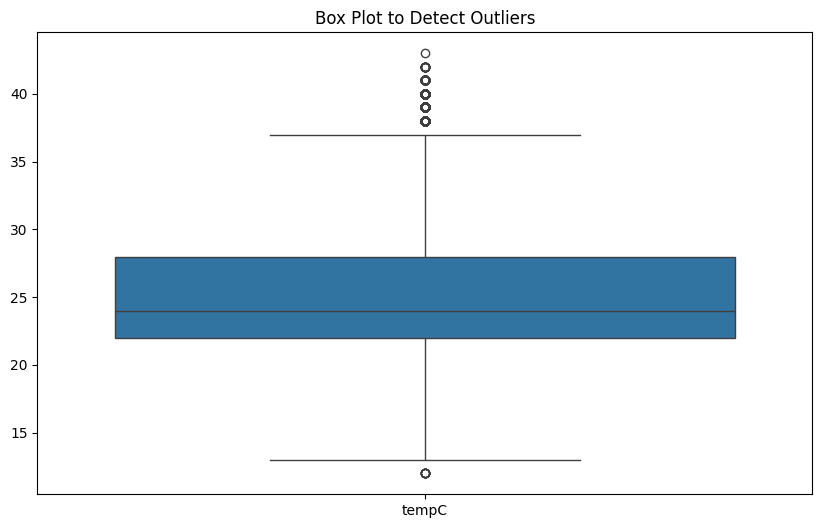

Number of outliers in Temperature: 1718
Original DataFrame shape: (113952, 16)
        year  tempC
1356    2009     38
1357    2009     38
1358    2009     38
1380    2009     38
1381    2009     38
...      ...    ...
107942  2021     39
107943  2021     39
107944  2021     39
107965  2021     38
107966  2021     38

[1718 rows x 2 columns]


In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=wf[['tempC']])#, 'humidity']])
plt.title('Box Plot to Detect Outliers')
plt.show()

Q1 = wf['tempC'].quantile(0.25)
Q3 = wf['tempC'].quantile(0.75)
IQR = Q3 - Q1

#Q5 = wf['humidity'].quantile(0.25)
#Q7 = wf['humidity'].quantile(0.75)
#IQR1 = Q7 - Q5

outliers_tempC = wf[(wf['tempC'] < (Q1 - 1.5 * IQR)) | (wf['tempC'] > (Q3 + 1.5 * IQR))]

#outliers_humidity = wf[(wf['humidity'] < (Q5 - 1.5 * IQR)) | (wf['humidity'] > (Q7 + 1.5 * IQR))]

print("Number of outliers in Temperature:", len(outliers_tempC))
#print("Number of outliers in Humidity:", len(outliers_humidity))
print("Original DataFrame shape:", wf.shape)
print(outliers_tempC[['year', 'tempC']])
#print(outliers_humidity[['year', 'humidity']])



Original DataFrame shape: (113952, 16)
DataFrame without outliers shape: (112234, 16)
Number of outliers in Temperature: 112234
            date_time  maxtempC  mintempC  FeelsLikeC  HeatIndexC  WindChillC  \
0 2009-01-01 00:00:00        31        17          17          17          17   
1 2009-01-01 01:00:00        31        17          17          17          17   
2 2009-01-01 02:00:00        31        17          17          17          17   
3 2009-01-01 03:00:00        31        17          17          17          17   
4 2009-01-01 04:00:00        31        17          17          17          17   

   WindGustKmph  humidity  precipMM  pressure  tempC location  year  month  \
0             7        50       0.0      1013     17     pune  2009      1   
1             9        46       0.0      1013     17     pune  2009      1   
2            10        43       0.0      1013     17     pune  2009      1   
3            12        40       0.0      1013     17     pune  2009      

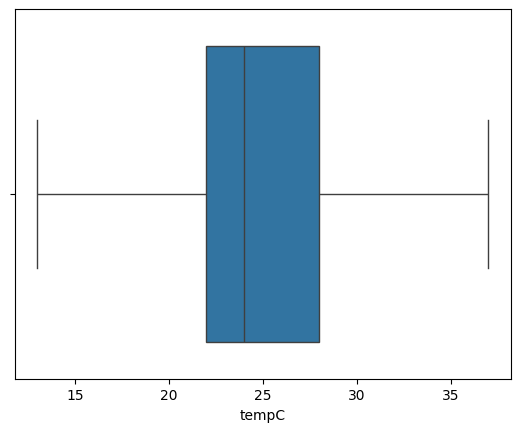

In [16]:
wf_no_outliers = wf[(wf['tempC'] >= (Q1 - 1.5 * IQR)) & (wf['tempC'] <= (Q3 + 1.5 * IQR))]
wf_no_outliers.tail()

print("Original DataFrame shape:", wf.shape)
print("DataFrame without outliers shape:", wf_no_outliers.shape)

sns.boxplot(x=wf_no_outliers['tempC'])
print("Number of outliers in Temperature:", len(wf_no_outliers))
print(wf_no_outliers.head())

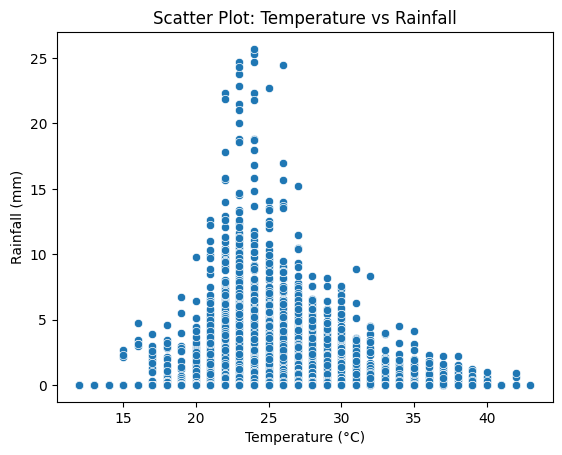

          tempC  precipMM
year                     
2009  25.416210  0.262340
2010  24.967808  0.269829
2011  25.084817  0.236416
2012  25.401753  0.155886
2013  25.117009  0.245959
2014  25.387100  0.207591
2015  25.354566  0.154749
2016  25.123634  0.259791
2017  25.451027  0.265982
2018  25.830023  0.188276
2019  25.528311  0.317146
2020  25.433629  0.302209
2021  25.333219  0.202489


In [17]:
sns.scatterplot(x='tempC', y='precipMM', data=wf)
plt.title('Scatter Plot: Temperature vs Rainfall')
plt.xlabel('Temperature (°C)')
plt.ylabel('Rainfall (mm)')
plt.show()

wfs =wf.groupby('year')[['tempC','precipMM']].mean()
print(wfs)


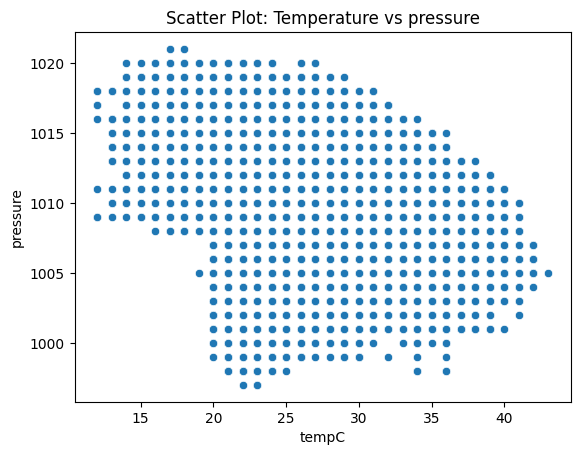

In [18]:
sns.scatterplot(x='tempC', y='pressure', data=wf)
plt.title("Scatter Plot: Temperature vs pressure")
plt.show()


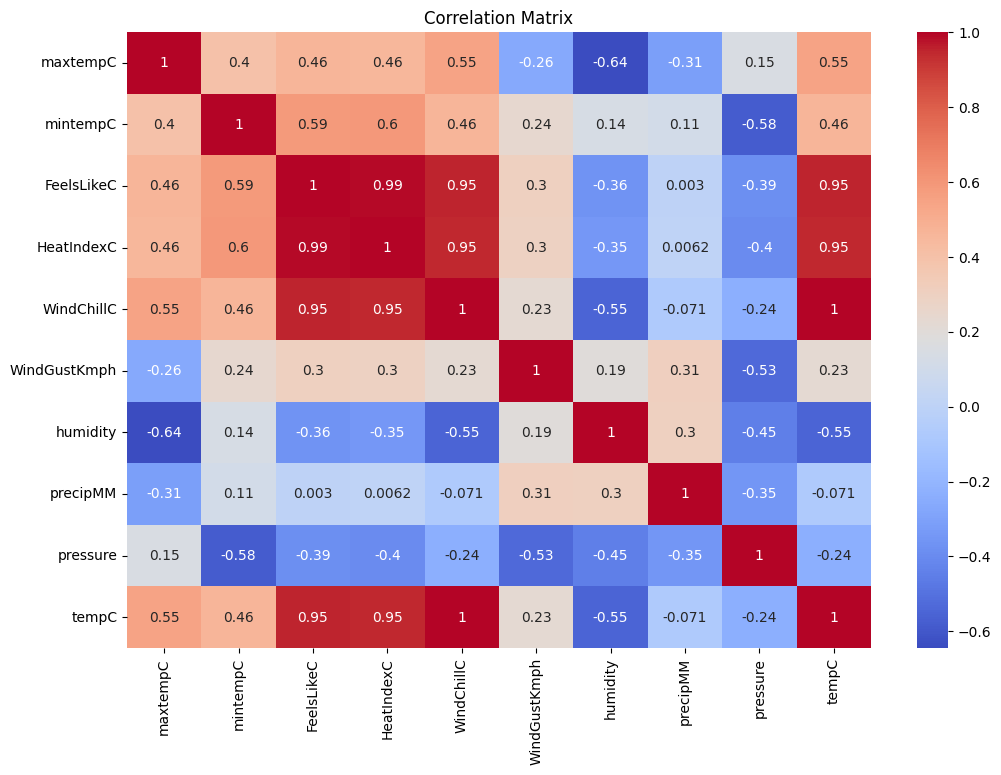

In [19]:
numeric_data = wf.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [37]:
wf_no_outliers.set_index('date_time', inplace=True)

wf_daily_data = wf_no_outliers[['tempC', 'humidity', 'pressure']].resample('D').mean()

print(wf_daily_data.head(30))

wf_daily_data.tail()

                tempC   humidity     pressure
date_time                                    
2009-01-01  22.541667  37.875000  1012.791667
2009-01-02  22.125000  44.000000  1013.750000
2009-01-03  22.583333  47.791667  1014.708333
2009-01-04  22.208333  52.791667  1013.583333
2009-01-05  22.458333  51.833333  1011.791667
2009-01-06  22.250000  47.583333  1011.833333
2009-01-07  22.041667  40.125000  1012.666667
2009-01-08  22.958333  42.541667  1014.458333
2009-01-09  22.875000  54.625000  1015.625000
2009-01-10  23.875000  54.708333  1014.958333
2009-01-11  24.541667  44.666667  1015.000000
2009-01-12  24.416667  43.208333  1016.916667
2009-01-13  23.250000  40.791667  1018.166667
2009-01-14  23.666667  37.125000  1018.416667
2009-01-15  23.500000  36.791667  1017.541667
2009-01-16  23.500000  38.166667  1017.083333
2009-01-17  23.291667  41.208333  1015.583333
2009-01-18  23.750000  40.250000  1014.375000
2009-01-19  24.166667  35.500000  1014.208333
2009-01-20  24.041667  29.750000  

,tempC,humidity,pressure
date_time,,,
2021-12-27,23.083333,44.208333,1014.708333
2021-12-28,22.833333,53.500000,1013.750000
2021-12-29,21.250000,53.333333,1014.083333
2021-12-30,21.250000,54.458333,1015.666667
2021-12-31,22.625000,48.416667,1016.333333


In [48]:
wf.head()

,maxtempC,mintempC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,humidity,precipMM,pressure,tempC,location,year,month,day,hour
date_time,,,,,,,,,,,,,,,
2009-01-01 00:00:00,31,17,17,17,17,7,50,0.0,1013,17,pune,2009,1,1,0
2009-01-01 01:00:00,31,17,17,17,17,9,46,0.0,1013,17,pune,2009,1,1,1
2009-01-01 02:00:00,31,17,17,17,17,10,43,0.0,1013,17,pune,2009,1,1,2
2009-01-01 03:00:00,31,17,17,17,17,12,40,0.0,1013,17,pune,2009,1,1,3
2009-01-01 04:00:00,31,17,17,17,17,11,38,0.0,1013,17,pune,2009,1,1,4


preprocessing

In [ ]:
scaler = MinMaxScaler()
wf_daily_data[['tempC', 'humidity', 'pressure']] = scaler.fit_transform(wf_daily_data[['tempC', 'humidity', 'pressure']])

wf_daily_data['temp_lag_1'] = wf_daily_data['tempC'].shift(1)
wf_daily_data['humidity_lag_1'] = wf_daily_data['humidity'].shift(1)
print(wf_daily_data.head())

wf_daily_data.fillna(method = 'bfill',inplace=True)
wf_daily_data.head()

train = wf_daily_data[wf_daily_data.index <= pd.to_datetime('2019-01-01')]
test = wf_daily_data[wf_daily_data.index > pd.to_datetime('2019-01-01')]

plt.figure(figsize=(12, 6))
plt.plot(wf_daily_data.index,wf_daily_data['tempC'], label='Temperature')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

result = seasonal_decompose(wf['tempC'], model='additive', period=365)
result.plot()
plt.show()

In [ ]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary.")

check_stationarity(wf['tempC'])